# Predicting ENSO
### Source: Libby Barnes
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code/)

### Backwards Optimization Code by: Ryan Lagerquist & DJ Gagne
### Edited by: Kirsten Mayer & Will Chapman
Here we are training a classifier to predict whether an El Nino or La Nina event is occuring. The input is a map of global SST, and the output is a classification of either 1=El Nino or 0=La Nino

### Load Libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import copy
import scipy

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras import backend as K
sys.setrecursionlimit(1500)

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12


from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential


#plotting with Cartopy. 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib import rc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker

import scipy as sp
import scipy.ndimage

2023-06-06 17:24:19.149190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 17:24:19.300217: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 17:24:19.342684: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-06 17:24:20.204251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 


### Backwards Optimization

The next cell defines methods that do backwards optimization (or "feature optimization"; Olah *et al.* 2017).  The goal of backwards optimization is to create synthetic input data that maximize the activation of some model component.  "Some model component" could be any of the following (figure from https://distill.pub/2018/building-blocks/).

 - Neuron activation: spatial position $(i, j)$ in channel $k$ of layer $L$
 - Channel activation: all spatial positions in channel $k$ of layer $L$
 - Layer activation: all spatial positions in all channels of layer $L$
 - Spatial activation: spatial position $(i, j)$ in all channels of layer $L$
 - Final prediction: probability that max future storm vorticity $\ge$ threshold
 
<img src="./model_components.png" alt="Model components" width="1000" />

Backwards optimization uses gradient descent to create synthetic input data ($32 \times 32$ grids of reflectivity, temperature, $u$-wind, and $v$-wind).  Gradient descent requires an initial seed, which could be any of the following:

 - Uniform grids ($e.g.$, all zeros or all ones)
 - Random grids ($e.g.$, Gaussian noise)
 - A real dataset example

We will use real dataset examples, because these produce the most physically realistic output.

In [2]:
def smooth_it(Patty):
    sigma_y = 1.5
    sigma_x = 1.5
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.gaussian_filter(Patty, sigma, mode='constant')
    return y


def _gradient_descent_for_bwo(
        cnn_model_object, loss_tensor, init_function_or_matrices,
        num_iterations, learning_rate):
    """Does gradient descent (the nitty-gritty part) for backwards optimization.

    :param cnn_model_object: Trained instance of `keras.models.Model`.
    :param loss_tensor: Keras tensor, defining the loss function to be
        minimized.
    :param init_function_or_matrices: Either a function or list of numpy arrays.

    If function, will be used to initialize input matrices.  See
    `create_gaussian_initializer` for an example.

    If list of numpy arrays, these are the input matrices themselves.  Matrices
    should be processed in the exact same way that training data were processed
    (e.g., normalization method).  Matrices must also be in the same order as
    training matrices, and the [q]th matrix in this list must have the same
    shape as the [q]th training matrix.

    :param num_iterations: Number of gradient-descent iterations (number of
        times that the input matrices are adjusted).
    :param learning_rate: Learning rate.  At each iteration, each input value x
        will be decremented by `learning_rate * gradient`, where `gradient` is
        the gradient of the loss function with respect to x.
    :return: list_of_optimized_input_matrices: length-T list of optimized input
        matrices (numpy arrays), where T = number of input tensors to the model.
        If the input arg `init_function_or_matrices` is a list of numpy arrays
        (rather than a function), `list_of_optimized_input_matrices` will have
        the exact same shape, just with different values.
    """

    if isinstance(cnn_model_object.input, list):
        list_of_input_tensors = cnn_model_object.input
    else:
        list_of_input_tensors = [cnn_model_object.input]

    num_input_tensors = len(list_of_input_tensors)
    
    print(loss_tensor)
    print(list_of_input_tensors)
        
    list_of_gradient_tensors = tf.compat.v1.keras.backend.gradients(loss_tensor, list_of_input_tensors)     
    
    for i in range(num_input_tensors):
        list_of_gradient_tensors[i] /= K.maximum(
            K.sqrt(K.mean(list_of_gradient_tensors[i] ** 2)),
            K.epsilon()
        )

    inputs_to_loss_and_gradients = K.function(
        list_of_input_tensors + [K.learning_phase()],
        ([loss_tensor] + list_of_gradient_tensors)
    )

    if isinstance(init_function_or_matrices, list):
        list_of_optimized_input_matrices = copy.deepcopy(
            init_function_or_matrices)
    else:
        list_of_optimized_input_matrices = [None] * num_input_tensors

        for i in range(num_input_tensors):
            these_dimensions = np.array(
                [1] + list_of_input_tensors[i].get_shape().as_list()[1:],
                dtype=int)

            list_of_optimized_input_matrices[i] = init_function_or_matrices(
                these_dimensions)

    for j in range(num_iterations):
        these_outputs = inputs_to_loss_and_gradients(
            list_of_optimized_input_matrices + [0])

        if np.mod(j, 1000) == 0:
            print('Loss after {0:d} of {1:d} iterations: {2:.2e}'.format(
                j, num_iterations, these_outputs[0]))

        for i in range(num_input_tensors):
            list_of_optimized_input_matrices[i] -= (
                these_outputs[i + 1] * learning_rate)

    print('Loss after {0:d} iterations: {1:.2e}'.format(
        num_iterations, these_outputs[0]))
    return list_of_optimized_input_matrices


def bwo_for_class(
        cnn_model_object, target_class, init_function_or_matrices,
        num_iterations=4000,
        learning_rate=0.00000001):
    """Does backwards optimization to maximize probability of target class.

    :param cnn_model_object: Trained instance of `keras.models.Model`.
    :param target_class: Synthetic input data will be created to maximize
        probability of this class.
    :param init_function_or_matrices: See doc for `_gradient_descent_for_bwo`.
    :param num_iterations: Same.
    :param learning_rate: Same.
    :return: list_of_optimized_input_matrices: Same.
    """

    target_class = int(np.round(target_class))
    num_iterations = int(np.round(num_iterations))

    assert target_class >= 0
    assert num_iterations > 0
    assert learning_rate > 0.
    assert  learning_rate < 1.

    num_output_neurons = (
        cnn_model_object.layers[-1].output.get_shape().as_list()[-1]
    )

    if num_output_neurons == 1:
        assert target_class <= 1

        if target_class == 1:
            loss_tensor = K.mean(
                (cnn_model_object.layers[-1].output[..., 0] - 1) ** 2
            )
        else:
            loss_tensor = K.mean(
                cnn_model_object.layers[-1].output[..., 0] ** 2
            )
    else:
        assert target_class < num_output_neurons

        loss_tensor = K.mean(
            (cnn_model_object.layers[-1].output[..., target_class] - 1) ** 2
        )

    return _gradient_descent_for_bwo(
        cnn_model_object=cnn_model_object, loss_tensor=loss_tensor,
        init_function_or_matrices=init_function_or_matrices,
        num_iterations=num_iterations, learning_rate=learning_rate)

## Preprocessing
Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. From this, we can calculate the Nino3.4 index.

In [3]:
filename = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
sstds = xr.open_dataset(filename,decode_times=False)
sst = sstds.sst
sst = sst.where((sst.lat <= 30) & (sst.lat >= -30), drop=True)
lat = np.asarray(sst.lat)
lon = np.asarray(sst.lon)
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))

## Data preparation
First, we need to include only samples where nino event is occuring (i.e. nino3.4>0.5 or nino3.4<-0.5). Then, we will divide the sst input and nino3.4 output into training, validation and testing chunks.

In [4]:
nino_occur = nino34[(nino34>0.5) | (nino34<-0.5)] # only samples where nino event occurs
nino_occur[nino_occur>0.5] = 1 # make into categorical format, 1 for El Nino and 0 for La Nina
nino_occur[nino_occur<0.5] = 0
nino_occur = tf.keras.utils.to_categorical(nino_occur) # format accepted by NN
sizefull = nino_occur.shape[0]

train_val_test = [0.7,0.85,1] # set train/val/test fraction

sst = np.asarray(sst)
sizesst = sst.shape
sstnino_occur = sst[(nino34>0.5) | (nino34<-0.5),:,:] # grab sst samples where nino occurs
sstnino_occur = np.reshape(sstnino_occur,(sizefull,sizesst[1]*sizesst[2])) # reshape latxlon to vectors

trainind = range(int(train_val_test[0]*sizefull))
valind = range(int(train_val_test[0]*sizefull),int(train_val_test[1]*sizefull))
testind = range(int(train_val_test[1]*sizefull),int(train_val_test[2]*sizefull))

# divide into training/validation/testing
sst_train = sstnino_occur[trainind,:]
sst_val = sstnino_occur[valind,:]
sst_test = sstnino_occur[testind,:]

nino_train  = nino_occur[trainind]
nino_val = nino_occur[valind]
nino_test = nino_occur[testind]

In [5]:
sst_std = np.std(sst_train,axis=0) # standardized by the TRAINING STD

sst_train = np.divide(sst_train,sst_std)
sst_train[np.isnan(sst_train)] = 0 # set all nans to zeros (they are learned to be ignored)
sst_val = np.divide(sst_val,sst_std)
sst_val[np.isnan(sst_val)] = 0
sst_test = np.divide(sst_test,sst_std)
sst_test[np.isnan(sst_test)] = 0

## Load Trained Neural Network

In [6]:
model = tf.keras.models.load_model('saved_model/ENSOmodel.h5')

2023-06-06 17:24:21.888748: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-06 17:24:21.888798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc12): /proc/driver/nvidia/version does not exist
2023-06-06 17:24:21.890038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 17:24:21.894602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


## OR make your own model!!

In [7]:
# parameters to play with

hiddens = [100, 100, 20] # hidden layers e.g. [10,20] means two hidden layers, 10 nodes connected to 20 nodes
ridgepen = 1 # L2/ridge penalty applied to input
lr = 1e-3 # learning rate
n_epochs = 20 # n training epochs
batch_size = 32 
activation = 'relu'
loss = 'categorical_crossentropy' 

Train on 324 samples, validate on 70 samples
Epoch 1/20
324/324 - 0s - loss: 1209.2342 - categorical_accuracy: 0.7191 - val_loss: 973.2090 - val_categorical_accuracy: 0.8571 - 231ms/epoch - 713us/sample
Epoch 2/20
324/324 - 0s - loss: 838.2575 - categorical_accuracy: 0.9722 - val_loss: 670.6348 - val_categorical_accuracy: 0.9429 - 43ms/epoch - 133us/sample
Epoch 3/20
324/324 - 0s - loss: 576.7159 - categorical_accuracy: 0.9877 - val_loss: 460.9218 - val_categorical_accuracy: 0.9571 - 43ms/epoch - 133us/sample
Epoch 4/20
324/324 - 0s - loss: 396.5608 - categorical_accuracy: 0.9969 - val_loss: 317.4179 - val_categorical_accuracy: 0.9857 - 44ms/epoch - 135us/sample
Epoch 5/20


/glade/u/home/kjmayer/.conda/envs/tf2-env/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


324/324 - 0s - loss: 273.4746 - categorical_accuracy: 0.9969 - val_loss: 219.4516 - val_categorical_accuracy: 0.9857 - 45ms/epoch - 140us/sample
Epoch 6/20
324/324 - 0s - loss: 189.4151 - categorical_accuracy: 1.0000 - val_loss: 152.3992 - val_categorical_accuracy: 1.0000 - 44ms/epoch - 135us/sample
Epoch 7/20
324/324 - 0s - loss: 131.7290 - categorical_accuracy: 1.0000 - val_loss: 106.2583 - val_categorical_accuracy: 1.0000 - 41ms/epoch - 127us/sample
Epoch 8/20
324/324 - 0s - loss: 91.9713 - categorical_accuracy: 1.0000 - val_loss: 74.3498 - val_categorical_accuracy: 1.0000 - 37ms/epoch - 115us/sample
Epoch 9/20
324/324 - 0s - loss: 64.4319 - categorical_accuracy: 1.0000 - val_loss: 52.1835 - val_categorical_accuracy: 1.0000 - 43ms/epoch - 134us/sample
Epoch 10/20
324/324 - 0s - loss: 45.2667 - categorical_accuracy: 1.0000 - val_loss: 36.7222 - val_categorical_accuracy: 1.0000 - 39ms/epoch - 120us/sample
Epoch 11/20
324/324 - 0s - loss: 31.8781 - categorical_accuracy: 1.0000 - val_lo

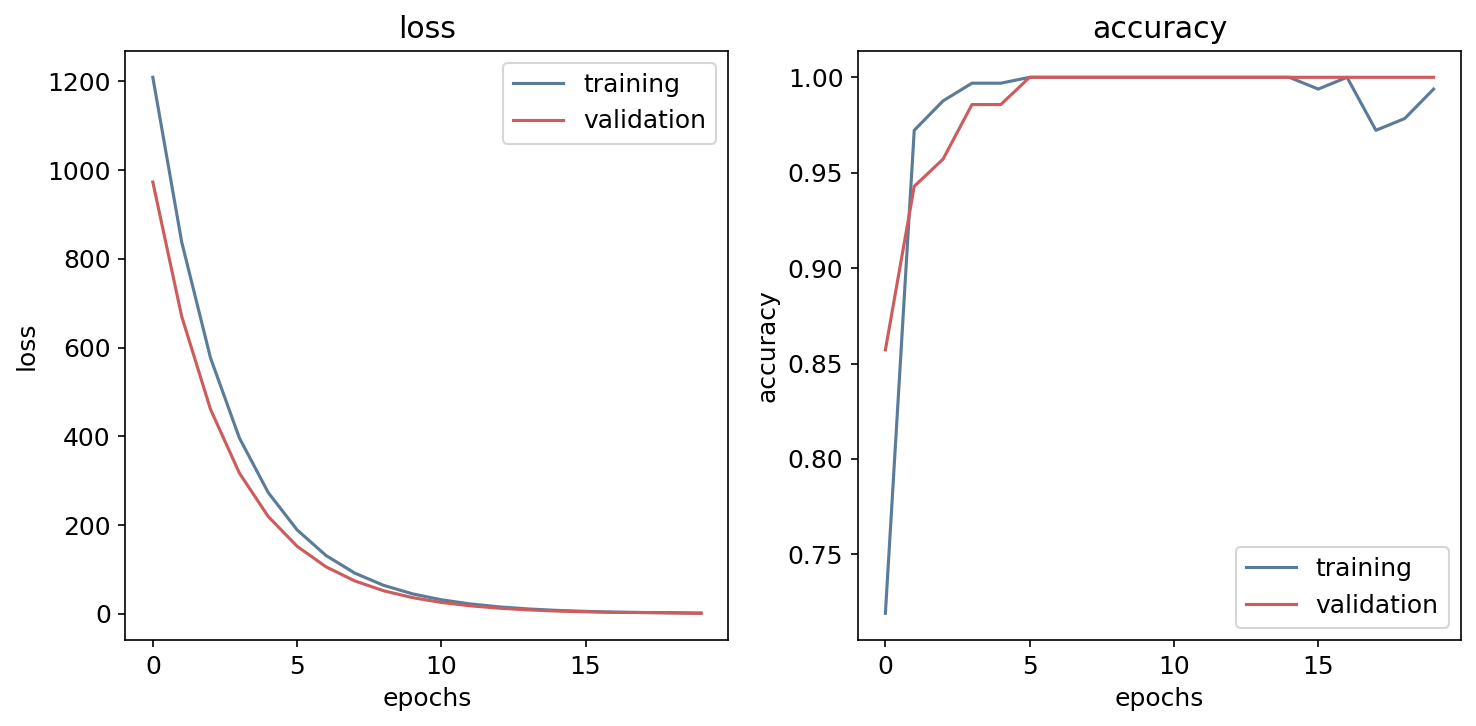

In [8]:
n_layers = len(hiddens)
output_nodes = 2

# define the model
model = Sequential()

model.add(Dense(hiddens[0], activation=activation,input_shape=(sst_train.shape[-1],),
            bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
            kernel_regularizer=regularizers.L2(l2=ridgepen)))

# add hidden layers
for layer in range(1,n_layers):
    model.add(Dense(hiddens[layer], activation=activation,
                    bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                    kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed)))

# final layer
model.add(Dense(output_nodes,activation='softmax',
                bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),))

# compile
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr),  
              loss=loss,   
              metrics=[metrics.categorical_accuracy]) 

# train
history = model.fit(sst_train, nino_train, epochs=n_epochs, batch_size=batch_size, validation_data=(sst_val, nino_val), 
                    shuffle=True, verbose=2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],color='xkcd:slate blue',label='training')
plt.plot(history.history['val_loss'],color='indianred',label='validation')
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'],color='xkcd:slate blue',label='training')
plt.plot(history.history['val_categorical_accuracy'],color='indianred',label='validation')
plt.xlabel("epochs"); plt.ylabel("accuracy")
plt.title("accuracy")
plt.legend()

plt.tight_layout()

## Model evaluation
How does the model do on unseen data?

In [9]:
nino_pred = model.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

modelcorr = nino_pred==nino_true
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = nino_true.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

Model accuracy on testing is 97.142857%


/glade/u/home/kjmayer/.conda/envs/tf2-env/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


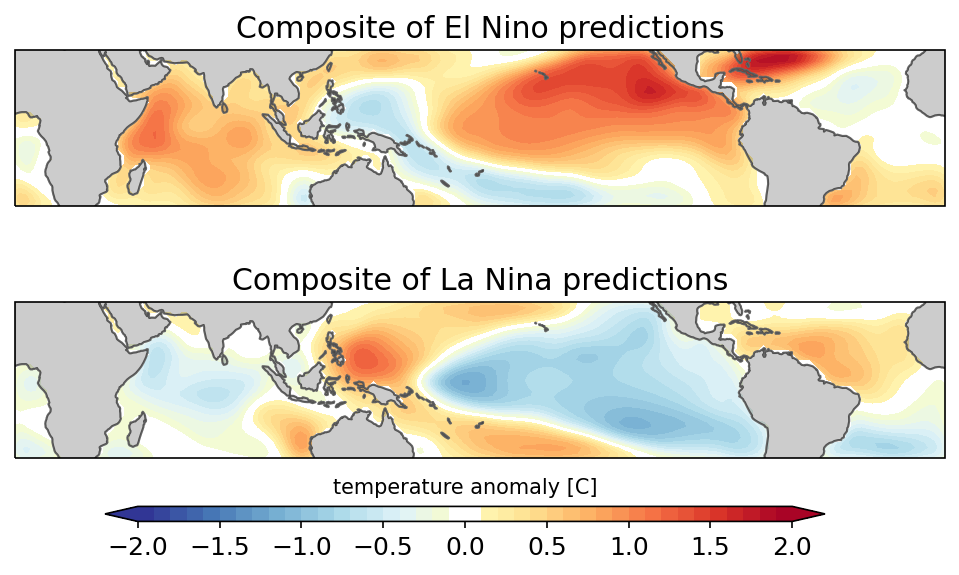

In [10]:
elninopred = (nino_pred==1)
laninapred = (nino_pred==0)

elnino_sst = sst_test[elninopred,:]
elnino_sst = np.reshape(elnino_sst,(elnino_sst.shape[0],sizesst[1],sizesst[2]))
lanina_sst = sst_test[laninapred,:]
lanina_sst = np.reshape(lanina_sst,(lanina_sst.shape[0],sizesst[1],sizesst[2]))

elninoplot = np.mean(elnino_sst,axis=0)
laninaplot = np.mean(lanina_sst,axis=0)



## +++ cmap 
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(0)
 # make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)
for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
# define the contour levels and normalize
clevels=(np.arange(-2,2.1,0.1))
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
## --- cmap 


land_mask = ((np.abs(sst[0,:,:].squeeze())>0)*1)
land_mask = np.where(land_mask==0, np.nan, land_mask)
projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()
fig = plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.contourf(lon,lat,smooth_it(elninoplot)*land_mask,levels=clevels,cmap=cmap,transform=transform)
ax1.coastlines(color='gray')
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k',facecolor='k',alpha=0.2)
plt.title('Composite of El Nino predictions')

ax1=plt.subplot(2,1,2,projection=projection)
ax1.contourf(lon,lat,smooth_it(laninaplot)*land_mask,levels=clevels,cmap=cmap,transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of La Nina predictions')
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k',facecolor='k',alpha=0.2)

#colorbar
ax2 = fig.add_axes([0.2, 0.05, 0.6, 0.025])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both',orientation='horizontal', spacing='proportional')
cb.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
plt.title('temperature anomaly [C]',fontsize=10)
plt.show()

## Calculate Backwards Optimization

In [11]:
elnino_optimized_predictor_matrix_norm = bwo_for_class(
    cnn_model_object=model, target_class=1,
    init_function_or_matrices=[np.expand_dims(0*np.random.random(size=len(sst_train[0,:])),axis=0)],
    num_iterations=4000,
    learning_rate=0.001
)

lanina_optimized_predictor_matrix_norm = bwo_for_class(
    cnn_model_object=model, target_class=0,
    init_function_or_matrices=[np.expand_dims(0*np.random.random(size=len(sst_train[0,:])),axis=0)],
    num_iterations=4000,
    learning_rate=0.001
)

Tensor("Mean:0", shape=(), dtype=float32)
[<tf.Tensor 'dense_input_1:0' shape=(None, 5580) dtype=float32>]
Loss after 0 of 4000 iterations: 2.23e-01
Loss after 1000 of 4000 iterations: 1.70e-07
Loss after 2000 of 4000 iterations: 7.99e-08
Loss after 3000 of 4000 iterations: 5.22e-08
Loss after 4000 iterations: 3.87e-08
Tensor("Mean_2:0", shape=(), dtype=float32)
[<tf.Tensor 'dense_input_1:0' shape=(None, 5580) dtype=float32>]
Loss after 0 of 4000 iterations: 2.79e-01
Loss after 1000 of 4000 iterations: 1.12e-07
Loss after 2000 of 4000 iterations: 5.30e-08
Loss after 3000 of 4000 iterations: 3.47e-08
Loss after 4000 iterations: 2.58e-08


## Reshape them to be SST[lat,lon]!

In [12]:
bwo_elnino_sstmap = elnino_optimized_predictor_matrix_norm[0].reshape(sizesst[1],sizesst[2])
bwo_lanina_sstmap = lanina_optimized_predictor_matrix_norm[0].reshape(sizesst[1],sizesst[2])

## Let's check... is it truly optimal?
An input that is "optimal": 
- el nino: [0,1]
- la nina: [1,0]

In [13]:
print('El Nino Optimal Input Prediction:')
print(np.round(model.predict(np.expand_dims(bwo_elnino_sstmap.reshape(lat.shape[0]*lon.shape[0]),axis=0))[0],3))
print('\nLa Nina Optimal Input Prediction:')
print(np.round(model.predict(np.expand_dims(bwo_lanina_sstmap.reshape(lat.shape[0]*lon.shape[0]),axis=0))[0],3))

El Nino Optimal Input Prediction:
[0. 1.]

La Nina Optimal Input Prediction:
[1. 0.]


## Yes? Plot the optimal SST input:

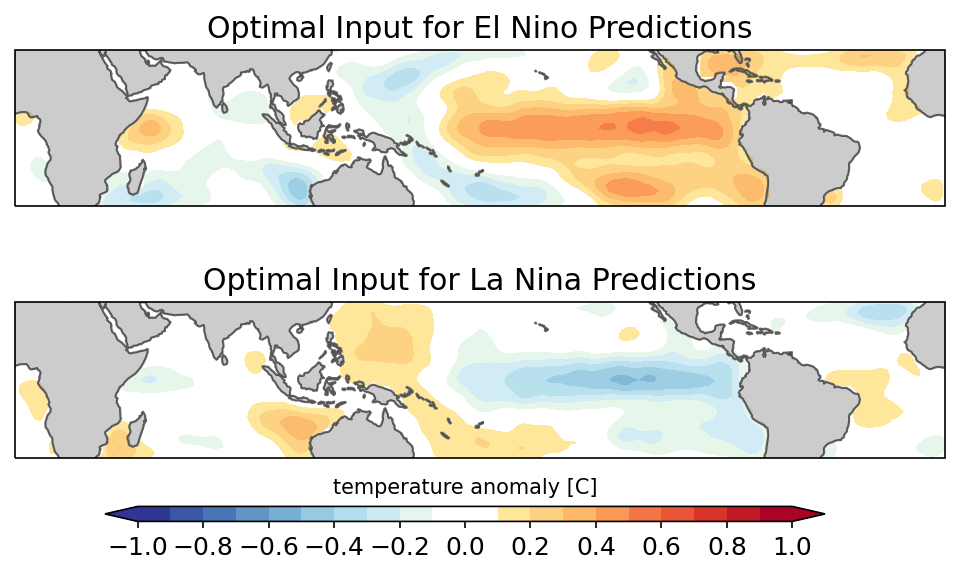

In [14]:
## +++ cmap 
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(0)
 # make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)
for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
# define the contour levels and normalize
clevels=(np.arange(-1,1.1,0.1))
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
## --- cmap 

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

land_mask = ((np.abs(sst[0,:,:].squeeze())>0)*1)
land_mask = np.where(land_mask==0, np.nan, land_mask)


fig = plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.contourf(lon,lat,smooth_it(bwo_elnino_sstmap)*land_mask,levels=clevels,cmap=cmap,transform=transform)
ax1.coastlines(color='gray')
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k',facecolor='k',alpha=0.2)
plt.title('Optimal Input for El Nino Predictions')

ax1=plt.subplot(2,1,2,projection=projection)
ax1.contourf(lon,lat,smooth_it(bwo_lanina_sstmap)*land_mask,levels=clevels,cmap=cmap,transform=transform)
ax1.coastlines(color='gray')
plt.title('Optimal Input for La Nina Predictions')
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k',facecolor='k',alpha=0.2)

#colorbar
ax2 = fig.add_axes([0.2, 0.05, 0.6, 0.025])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both',orientation='horizontal', spacing='proportional')
cb.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
plt.title('temperature anomaly [C]',fontsize=10)
plt.show()
